In [1]:
import pandas as pd
import numpy as np
import datetime
import os

from utils import one_hot_encoder, loadpkl

num_rows=None

%matplotlib inline

In [2]:
# load datasets

historical_transactions = pd.read_csv('../input/historical_transactions.csv')
merchants = pd.read_csv('../input/merchants.csv')
new_merchant_transactions = pd.read_csv('../input/new_merchant_transactions.csv')
sample_submission = pd.read_csv('../input/sample_submission.csv')
test = pd.read_csv('../input/test.csv', index_col=['card_id'])
train = pd.read_csv('../input/train.csv', index_col=['card_id'])

In [3]:
# preprocessing
train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

new_merchant_transactions['category_2'].fillna(1.0,inplace=True)
new_merchant_transactions['category_3'].fillna('A',inplace=True)
new_merchant_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
new_merchant_transactions['installments'].replace(-1, np.nan,inplace=True)
new_merchant_transactions['installments'].replace(999, np.nan,inplace=True)
new_merchant_transactions['purchase_date']=pd.to_datetime(new_merchant_transactions['purchase_date'])
new_merchant_transactions['authorized_flag'] = new_merchant_transactions['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
new_merchant_transactions['category_1'] = new_merchant_transactions['category_1'].map({'Y': 1, 'N': 0}).astype(int)
new_merchant_transactions['category_3'] = new_merchant_transactions['category_3'].map({'A':0, 'B':1, 'C':2})

historical_transactions['category_2'].fillna(1.0,inplace=True)
historical_transactions['category_3'].fillna('A',inplace=True)
historical_transactions['merchant_id'].fillna('M_ID_00a6ca8a8a',inplace=True)
historical_transactions['installments'].replace(-1, np.nan,inplace=True)
historical_transactions['installments'].replace(999, np.nan,inplace=True)
historical_transactions['purchase_date']=pd.to_datetime(historical_transactions['purchase_date'])
historical_transactions['authorized_flag'] = historical_transactions['authorized_flag'].map({'Y': 1, 'N': 0}).astype(int)
historical_transactions['category_1'] = historical_transactions['category_1'].map({'Y': 1, 'N': 0}).astype(int)
historical_transactions['category_3'] = historical_transactions['category_3'].map({'A':0, 'B':1, 'C':2})

In [9]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_4e6213e9bc,88,0,0.0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,C_ID_4e6213e9bc,88,0,0.0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,1,C_ID_4e6213e9bc,88,0,0.0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,1,C_ID_4e6213e9bc,88,0,0.0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,1,C_ID_4e6213e9bc,88,0,0.0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [10]:
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [11]:
new_merchant_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,1,C_ID_415bb3a509,107,0,1.0,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,1,C_ID_415bb3a509,140,0,1.0,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,1,C_ID_415bb3a509,330,0,1.0,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,1,C_ID_415bb3a509,-1,1,1.0,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,1.0,-1,8
4,1,C_ID_ef55cf8d4b,-1,1,1.0,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,1.0,-1,29


In [6]:
sample_submission.head()

,card_id,target
0,C_ID_0ab67a22ab,0
1,C_ID_130fd0cbdd,0
2,C_ID_b709037bc5,0
3,C_ID_d27d835a9f,0
4,C_ID_2b5e3df5c2,0


In [7]:
test.head()

,first_active_month,feature_1,feature_2,feature_3
card_id,,,,
C_ID_0ab67a22ab,2017-04,3,3,1
C_ID_130fd0cbdd,2017-01,2,3,0
C_ID_b709037bc5,2017-08,5,1,1
C_ID_d27d835a9f,2017-12,2,1,0
C_ID_2b5e3df5c2,2015-12,5,1,1


In [8]:
train.head()

,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
C_ID_92a2005557,2017-06,5,2,1,-0.820283
C_ID_3d0044924f,2017-01,4,1,0,0.392913
C_ID_d639edf6cd,2016-08,2,2,0,0.688056
C_ID_186d6a6901,2017-09,4,3,0,0.142495
C_ID_cdbd2c0db2,2017-11,1,3,0,-0.159749


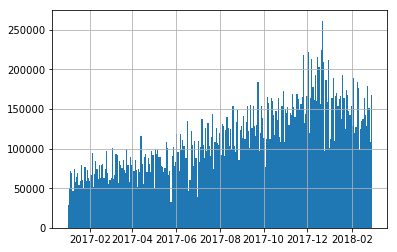

In [12]:
historical_transactions.purchase_date.hist(bins=255)

In [ ]:
historical_transactions.purchase_date.hist(bins=255)

In [3]:
np.round(historical_transactions['purchase_amount'] / 0.00150265118 + 497.06,8)

0             29.000001
1              9.170003
2             17.650001
3              7.689999
4             15.999998
5              7.999997
6             20.000001
7             59.800003
8              5.950001
9             21.000000
10             8.500000
11            12.630001
12             3.499998
13            13.000000
14            10.000002
15             5.799999
16            13.999999
17             7.999997
18            31.399999
19             1.000003
20             7.999997
21             5.950001
22             4.900003
23            13.249998
24            10.000002
25             7.500001
26            13.600000
27            13.400000
28            16.999997
29            36.400002
               ...     
29112331       1.420001
29112332     469.980003
29112333     831.770002
29112334     834.389998
29112335      43.499999
29112336      25.300000
29112337      99.999998
29112338     130.830001
29112339      94.000003
29112340      27.899998
29112341      27

In [22]:
X =2**train['target']

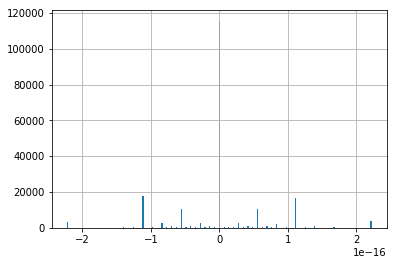

In [27]:
(np.log2(X) - train['target']).hist(bins=255)

In [29]:
X.max()

255873.0008725488

In [31]:
np.round(2**-33.21928095,2)

0.0